# Data preprocessing
This notebook is based on chapter 12 of the book [*Time Series Forecasting in Python*](https://www.manning.com/books/time-series-forecasting-in-python-book) by Marco Peixeiro. We analyze the preprocessed dataset for the metro interstate traffic volume. This dataset is a subset of the original data available from the UCI repository.

In [6]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
print("NumPy version: %s"%np.__version__)
print('Pandas version: %s'%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
matplotlib version: 3.8.4


The dataset contains 17551 observations

In [268]:
metro_interstate_traffic_volume_preprocessed = pd.read_csv('data/metro_interstate_traffic/metro_interstate_traffic_volume_preprocessed.csv')
metro_interstate_traffic_volume_preprocessed.shape

(17551, 6)

The dataset begins on Thursday 29 September 2016 at 5pm. There are 6 features: time, temperature, rain, snow, cloud coverage, and traffic volume. We will use traffic volume and temperature as targets, the variables that we want to predict using the other features as input data and a model. 

In [271]:
metro_interstate_traffic_volume_preprocessed.head(1)

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0


The last observation was made on Sunday 30 September 2018 at 11pm

In [274]:
metro_interstate_traffic_volume_preprocessed.tail(1)

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17550,2018-09-30 23:00:00,282.12,0.0,0,90,954.0


We plot the first 400 hours of observations. In 400 hours there are 16 days and 16 hours. The first 7 hours are observations made on Thursday 29 September 2016, so the first full day is Friday 30 September. Then we have 15 days more of full observations till Saturday 29 September 2018, for a total of 16 days of full observations, and then 9 more observations Sunday 30 September 2018, for a total of 17 weekdays. 

In [277]:
day_enum = ['Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday', 
            'Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday',
            'Friday',
            'Saturday', 
            'Sunday']

len(day_enum)

17

## Traffic volume
We plot the first target variable: the traffic volume

In [280]:
traffic_volume = metro_interstate_traffic_volume_preprocessed['traffic_volume']

We set the ticks on the time axis for each day starting with a Friday, 7 hours after the first observation in the sample of 400 hours

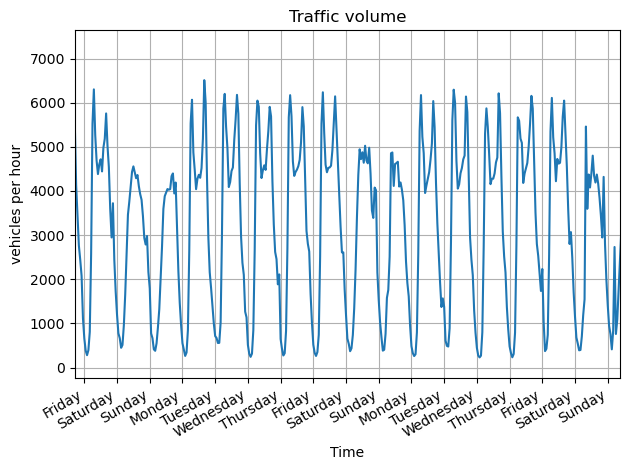

In [283]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(traffic_volume)
ax.set_title('Traffic volume')
ax.set_xlabel('Time')
ax.set_ylabel('vehicles per hour')
ax.grid(True, which='both')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

We can see that the traffic volume follows a daily periodicity and another one in the weekends in which the trafffic volume is lower than in the weekdays (Monday to Friday).

## Temperature
We plot the temperature in the same time window of the traffic volume. For the temperature we can observe a daily periodicity and a seasonal periodicity.

In [287]:
temperature = metro_interstate_traffic_volume_preprocessed['temp']

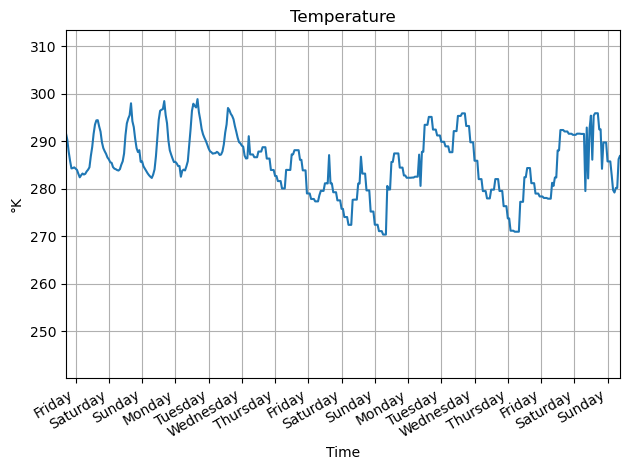

In [289]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(temperature)
ax.set_title('Temperature')
ax.set_xlabel('Time')
ax.set_ylabel('°K')
ax.grid(True, which='both')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

We can see the seasonal periodicity using a larger sample.

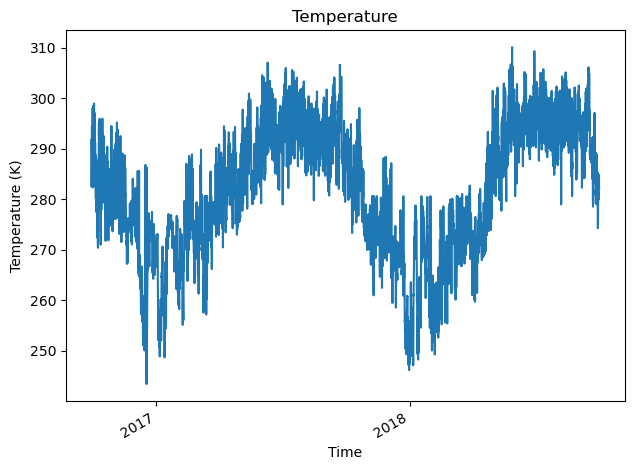

In [292]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.set_title('Temperature')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')
plt.xticks([2239, 10999], [2017, 2018])
plt.tight_layout()
ax.plot(temperature)

## Feature engineering
We want to select the features that have a causal relationship with the targets. 

In [295]:
metro_interstate_traffic_volume_preprocessed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


We can see that 75% of the observations for the rain is 0 so it cannot be used to predict the traffic volume nor the temperature. Even more so for the snow that is always 0. We can remove these two features from the dataset since they are useless for the task at hand.

In [298]:
df = metro_interstate_traffic_volume_preprocessed.drop(['rain_1h', 'snow_1h'], axis=1)
df.shape

(17551, 4)

In [300]:
df.head(1)

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0


## Date and time cyclical encoding
We want to use the date and time as an input feature. In the dataset date and time are provided as a string but we need to represent the time as a numerical value. We can do that by computing for each date time the number of seconds from a reference day.

In [303]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)
sec_per_day = 24 * 60 * 60

Representing the time as the number of seconds from a reference day doesn't work well for our purpose because it increases linearly while we want to represent its cyclical nature. 

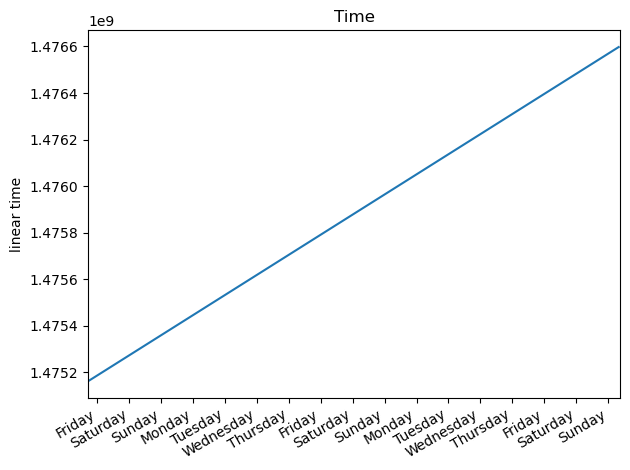

In [306]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(timestamp_s[:400])
ax.set_title('Time')
ax.set_ylabel('linear time')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

We apply a cyclical transformation to the time so that it can represent the daily cycle

In [309]:
day_sin = np.sin(timestamp_s * (2 * np.pi / sec_per_day)).values

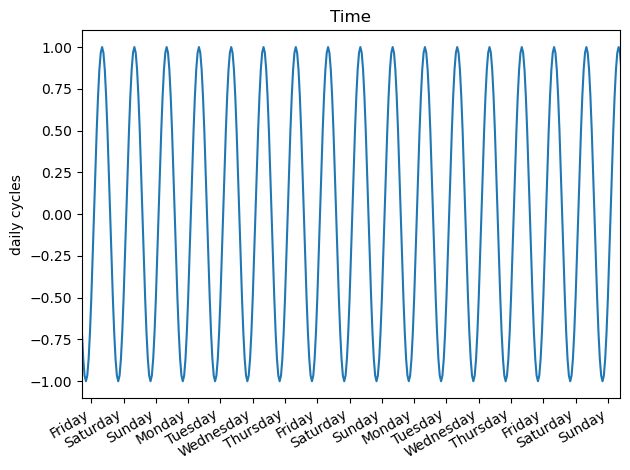

In [311]:
fig, ax = plt.subplots()
fig.autofmt_xdate()
ax.plot(day_sin)
ax.set_title('Time')
ax.set_ylabel('daily cycles')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

A sinusoidal transformation maps only half day to a unique value but we need to map each hour in a day to only one cyclical value. We can achieve this result by using an additional, e.g. cosine, transformation 

In [314]:
day_cos = (np.cos(timestamp_s * (2 * np.pi / sec_per_day))).values

Now we replace the date_time field with the two transformations

In [317]:
df['day_sin'] = day_sin
df['day_cos'] = day_cos
df = df.drop(['date_time'], axis=1)
df.head(1)

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-0.707107,-0.707107


We can see that we can map each observation to only one point by using the two cyclical transformations of the time 

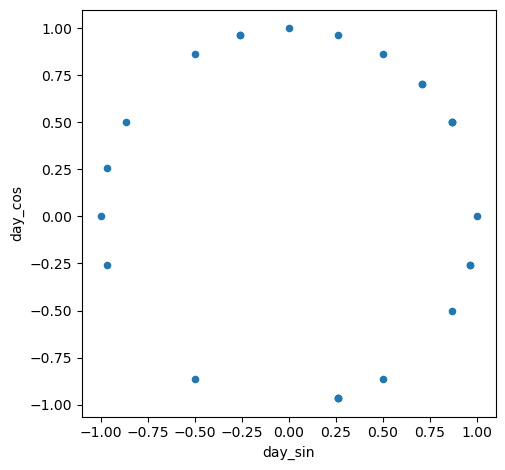

In [330]:
df.sample(24).plot.scatter('day_sin','day_cos').set_aspect('equal')
plt.tight_layout()

## Splitting the dataset into a train, validation, and test set
We split the data into 70-20-10 for training, validation, and test respectively

In [336]:
n = len(df)
train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
test_df = df[int(n * 0.9):]
train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

We use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from scikit-learn to scale the values

In [345]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_df)
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

C:\Users\Luigi\AppData\Local\Temp\ipykernel_8368\4156620498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
C:\Users\Luigi\AppData\Local\Temp\ipykernel_8368\4156620498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
C:\Users\Luigi\AppData\Local\Temp\ipykernel_8368\4156620498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [349]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12285.0,0.555681,0.196527,0.0,0.424800,0.557913,0.715072,1.0
clouds_all,12285.0,0.431034,0.393716,0.0,0.010000,0.400000,0.900000,1.0
traffic_volume,12285.0,0.445735,0.273635,0.0,0.165899,0.473141,0.671271,1.0
day_sin,12285.0,0.500020,0.353600,0.0,0.146447,0.500000,0.853553,1.0
day_cos,12285.0,0.500035,0.353536,0.0,0.146447,0.500000,0.853553,1.0


We save the three datasets as CSV files

In [352]:
train_df.to_csv('data/metro_interstate_traffic/train.csv')
val_df.to_csv('data/metro_interstate_traffic/val.csv')
test_df.to_csv('data/metro_interstate_traffic/test.csv')

## References
* [Lewinson - Three Approaches to Encoding Time Information as Features for ML Models](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
* [Pim - The best way to encode dates, times, and other cyclical features](https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features)
* [Möhl - How to Encode Periodic Time Features](https://towardsdatascience.com/how-to-encode-periodic-time-features-7640d9b21332/)